In [1]:
#Import needed packages from Python
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso



In [2]:
#NOT efficient - generating coefficients of stationary time seires data
def generate_stationary_ar_coefficients(p):

    # Infinite loop risk mitigation: Set a maximum number of attempts
    max_attempts = 1000
    attempts = 0
    
    while True:
        # Generate random coefficients for AR(p) within the range (-1, 1)
        phi = np.random.uniform(-10, 10, size=p)
        
        # Define the characteristic polynomial: z^p - phi_1 * z^(p-1) - ... - phi_p = 0
        char_poly = np.r_[1, -phi] 
        
        # Calculate the roots of the characteristic polynomial
        roots = np.roots(char_poly)
               
        # Check if all roots have magnitude greater than 1 (outside the unit circle)
        if np.all(np.abs(roots) > 1):
            return phi
        
        attempts += 1
        if attempts >= max_attempts:
            raise RuntimeError("Failed to generate stationary AR coefficients after 1000 attempts.")



In [3]:
#Efficient - generating coefficients of stationary time seires data
def generate_stationary_ar_coefficients_from_roots(p):
    # Choose p roots uniformly from [1.2, 5] U [-1.2, -5]
    roots = np.random.choice(np.concatenate((np.random.uniform(1.2, 5, p), np.random.uniform(-5, -1.2, p))), p, replace=False)
    
    # Convert the roots into AR coefficients by finding the coefficients of the polynomial with those roots
    # The characteristic polynomial is (z - root1)(z - root2)...(z - root_p) = 0
    # We need the coefficients of z^p - phi_1 z^(p-1) - ... - phi_p = 0
    poly_coefficients = np.poly(roots)  # Returns [1, -phi_1, -phi_2, ..., -phi_p]
    
    # Extract the AR(p) coefficients: phi_1, phi_2, ..., phi_p (they are negated by np.poly)
    ar_coefficients = -poly_coefficients[1:]  # Ignore the first element (leading coefficient 1)
    ar_coefficients /= np.sum(np.abs(ar_coefficients)) + 1.0
    return ar_coefficients


In [4]:
#generate AR time series with n=length, phi=coefficients, noise-std=noise standard deviation
def generate_ar_process(n, phi, noise_std):
    #initialize time series 
    y = np.zeros(n)
    #y[0] = 1
    #y[1] = 0.5
    #y[2] = 1
    # Generate white noise
    white_noise = np.random.normal(0, noise_std, n)

    # Order of the AR process (p = length of phi)
    p = len(phi)

    # Ensure the AR model has enough data points to generate the process
    if p >= n:
        raise ValueError("The length of the time series must be greater than the order of the AR process (p).")

    # Generate the AR(p) time series
    for t in range(p, n):
        y[t] = sum(phi[i] * y[t - i - 1] for i in range(p)) + white_noise[t]
    
    return y



In [5]:
#data parition for blocked cv
def partition_blocked_cv(time_series, k_folds=5):
    block_size = len(time_series) // k_folds
    partitions = np.zeros((k_folds,len(time_series)))
    for i in range(k_folds):
        test_set = time_series[i * block_size:(i + 1) * block_size]
        train_set = np.concatenate([time_series[:i * block_size], time_series[(i + 1) * block_size:]])
        partitions[i,:] = np.concatenate([train_set, test_set])
    return partitions


In [6]:
#data parition for leave-one-out cv
def partition_loocv(time_series):
    partitions = np.zeros((len(time_series),len(time_series)))
    #partitions = []
    for i in range(len(time_series)):
        test_set = [time_series[i]]
        train_set = np.concatenate([time_series[:i], time_series[i+1:]])
        partitions[i,:] = np.concatenate([train_set, test_set])
        #partitions.append(np.concatenate([train_set, test_set]))
    return partitions


In [7]:
#data parition for normal cv (randomly chosen test set)
def partition_normal_cv(time_series, k_folds=5):
    
    # Shuffle 
    np.random.shuffle(time_series)

    #same as blocked cv
    block_size = len(time_series) // k_folds
    partitions = np.zeros((k_folds,len(time_series)))
    for i in range(k_folds):
        test_set = time_series[i * block_size:(i + 1) * block_size]
        train_set = np.concatenate([time_series[:i * block_size], time_series[(i + 1) * block_size:]])
        partitions[i,:] = np.concatenate([train_set, test_set])
    return partitions
    


In [8]:
#function of mean absolute percentage error (not used in the formal experiment)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
#function of root mean squared error
def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [10]:
#function of mean absolute error
def mean_absolute_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

In [11]:
#function of mean error 
def mean_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_true - y_pred)

In [12]:
#function of AR with Lasso regression 
def ar_error(time_series, test_size, lags=3):
    test_set = time_series[-test_size:]
    train_set = time_series[:-test_size]
    if test_size == 1: 
        test_size = [test_size]

    #fit and predict
    model = AutoReg(train_set, lags=lags)
    model_fitted = model.fit()
    start = len(train_set)
    end = len(train_set)+len(test_set)-1
    y_predictions = model_fitted.predict(start=start, end=end, dynamic=False)

    #calculate the error
    rmse = root_mean_squared_error(test_set, y_predictions)
    mae = mean_absolute_error(test_set, y_predictions)

    return y_predictions, rmse, mae


In [13]:
#function of AR with Lasso regression 
def ar_lasso_error(time_series, test_size, lags, lasso_alpha):
    # Split the time series into training and testing sets
    test_set = time_series[-test_size:]
    train_set = time_series[:-test_size]
    
    num_data = len(train_set) - lags
    if num_data <= 0:
        raise ValueError("Not enough data to create lagged features with the given number of lags.")
    
    # Creating the lag matrix
    X = np.zeros((num_data, lags))
    for i in range(num_data): 
        X[i, :] = [train_set[(j + i)] for j in reversed(range(lags))]
    y = train_set[lags:]

    # Fit the Lasso AR model
    lasso_ar_model = make_pipeline(StandardScaler(), Lasso(alpha=lasso_alpha))
    lasso_ar_model.fit(X, y)
    
    # Initialize the known last values (y_known) to start making future predictions
    y_known = y[-lags:]  # Last lag values from the training set
    y_predictions = []  # Store predictions
    num_steps = test_size  # Number of steps to predict

    # Iteratively predict the next future value
    for _ in range(num_steps):
        X_future = np.array([y_known])
        next_pred = lasso_ar_model.predict(X_future)[0]  # Predict next step
        y_predictions.append(next_pred)
    
        # Shift the known values and add the new prediction
        y_known = np.roll(y_known, -1)
        y_known[-1] = next_pred  # Replace the oldest lag with the new prediction
        
    # Calculate the error
    rmse = root_mean_squared_error(test_set, y_predictions)
    mae = mean_absolute_error(test_set, y_predictions)

    return y_predictions, rmse, mae
    


In [14]:
#perform cv on time series data with chosen model type (ar or ar_lasso), the order p, cv type and out_set data percentage
#if the out-set percentage separates at middle of a data point, the data will be put into in_set
def cv_for_ts(in_set, lags, model_type="ar", lasso_alpha=0.1, partition_type="loocv", k_folds=None):
    if partition_type != "loocv" and k_folds is None:
        raise ValueError("Value of k_folds must be passed")
    
    #conduct partitions of the in_set data
    if partition_type == "blocked_cv":
        partitions = partition_blocked_cv(in_set, k_folds)
    if partition_type == "normal_cv":
        partitions = partition_normal_cv(in_set, k_folds)
    if partition_type == "loocv":
        partitions = partition_loocv(in_set)

    #conduct model fit and calculate the errors on in_set data
    if partition_type == "loocv":
        test_size = 1
    else: 
        test_size = len(in_set)//k_folds

    #empty lists to store errors
    in_set_rmse = []
    in_set_mae = []

    #if using general ar model with or without lasso term
    if model_type == "ar":
        for row in partitions: 
            y_predicted, rmse, mae = ar_error(row, test_size, lags)
            in_set_rmse.append(rmse)
            in_set_mae.append(mae)

    if model_type == "ar_lasso":
        for row in partitions: 
            y_predicted, rmse, mae = ar_lasso_error(row, test_size, lags, lasso_alpha)
            in_set_rmse.append(rmse)
            in_set_mae.append(mae)

    in_set_average_rmse = np.mean(in_set_rmse)
    in_set_average_mae = np.mean(in_set_mae)

    return in_set_average_rmse, in_set_average_mae



In [162]:
#Main execution: performs Monte Carlo trials on cross validation with ar model fitting 
# (both on in-set and on out-set), out_set_pct stands for the percentage of data saved for out-set


all_out_set_rmse_ar = []
all_out_set_mae_ar = []
all_out_set_rmse_arlasso_1 = []
all_out_set_mae_arlasso_1 = []
all_out_set_rmse_arlasso_2 = []
all_out_set_mae_arlasso_2 = []
all_out_set_rmse_arlasso_3 = []
all_out_set_mae_arlasso_3 = []

#the list of all errors, the model type is AR and the partition type is blocked CV (5 folds)
all_in_set_rmse_ar_blockedcv = []
all_in_set_mae_ar_blockedcv = []

#the list of all errors, the model type is AR with lasso and the partition type is blocked CV (5 folds)
all_in_set_rmse_arlasso_blockedcv_1 = []
all_in_set_mae_arlasso_blockedcv_1 = []
all_in_set_rmse_arlasso_blockedcv_2 = []
all_in_set_mae_arlasso_blockedcv_2 = []
all_in_set_rmse_arlasso_blockedcv_3 = []
all_in_set_mae_arlasso_blockedcv_3 = []

#the list of all errors, the model type is AR and the partition type is normal CV (5 folds)
all_in_set_rmse_ar_normalcv = []
all_in_set_mae_ar_normalcv = []

#the list of all errors, the model type is AR with lasso and the partition type is normal CV (5 folds)
all_in_set_rmse_arlasso_normalcv_1 = []
all_in_set_mae_arlasso_normalcv_1 = []
all_in_set_rmse_arlasso_normalcv_2 = []
all_in_set_mae_arlasso_normalcv_2 = []
all_in_set_rmse_arlasso_normalcv_3 = []
all_in_set_mae_arlasso_normalcv_3 = []

#the list of all errors, the model type is AR and the partition type is LOOCV (5 folds)
all_in_set_rmse_ar_loocv = []
all_in_set_mae_ar_loocv = []

#the list of all errors, the model type is AR with lasso and the partition type is LOOCV (5 folds)
all_in_set_rmse_arlasso_loocv_1 = []
all_in_set_mae_arlasso_loocv_1 = []
all_in_set_rmse_arlasso_loocv_2 = []
all_in_set_mae_arlasso_loocv_2 = []
all_in_set_rmse_arlasso_loocv_3 = []
all_in_set_mae_arlasso_loocv_3 = []

#the list of all errors, use OOS
all_in_set_rmse_ar_oos = []
all_in_set_mae_ar_oos = []

all_in_set_rmse_arlasso_oos_1 = []
all_in_set_mae_arlasso_oos_1 = []
all_in_set_rmse_arlasso_oos_2 = []
all_in_set_mae_arlasso_oos_2 = []
all_in_set_rmse_arlasso_oos_3 = []
all_in_set_mae_arlasso_oos_3 = []


#generating time series with length 200 for 1000 trials
for i in range(1000):  
    phi = generate_stationary_ar_coefficients_from_roots(8) #Used for Data generating process
    #phi = [1.37, -0.56, 0] #example of a stationary time series, our process worked fine with those values
    time_series = generate_ar_process(200, phi,noise_std=1)
    time_series = 2*(time_series - min(time_series))/(max(time_series) - min(time_series)) #normalizing
    time_series = time_series - min(time_series) + 1 #ensuring for only positive values
    #time_series = time_series[50:250] 
    lags = 8 #AR(lags) model for fitting
    model_type_1 = "ar"
    model_type_2 = "ar_lasso" 
    lasso_alpha = [0.1,0.6,1]
    partition_type_1 = "blocked_cv"
    partition_type_2 = "normal_cv" 
    partition_type_3 = "loocv"
    k_folds=5
    out_set_pct=0.3

    oos_pct =0.2

    #in-set and out-set partitions
    in_set_data = time_series[:int(-out_set_pct*len(time_series))]
    out_set_data = time_series[int(-out_set_pct*len(time_series)):]
    out_set_size = len(out_set_data)

    #model_type = ar & ar_lasso, parition_type = blocked_cv
    # first number stands for parition types: 1 for blocked cv, 2 for normal cv, 3 for loocv, 4 for oos
    # second number stands for model types: 1 for AR, 2 for AR with lasso
    # third number stands for error types for the CVs on th in-set data: 1 for rmse, 2 for mae
    # notice that for model type = 1, the lasso value doesn't matter (won't use it anyway)
    error_111, error_112 = cv_for_ts(in_set_data, lags, model_type_1, lasso_alpha[0], partition_type_1, k_folds)
    all_in_set_rmse_ar_blockedcv.append(error_111)
    all_in_set_mae_ar_blockedcv.append(error_112)

    error_121, error_122 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[0], partition_type_1, k_folds)
    all_in_set_rmse_arlasso_blockedcv_1.append(error_121)
    all_in_set_mae_arlasso_blockedcv_1.append(error_122)

    error_123, error_124 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[1], partition_type_1, k_folds)
    all_in_set_rmse_arlasso_blockedcv_2.append(error_123)
    all_in_set_mae_arlasso_blockedcv_2.append(error_124)

    error_125, error_126 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[2], partition_type_1, k_folds)
    all_in_set_rmse_arlasso_blockedcv_3.append(error_125)
    all_in_set_mae_arlasso_blockedcv_3.append(error_126)

    #model_type = ar & ar_lasso, parition_type = normal_cv
    error_211, error_212 = cv_for_ts(in_set_data, lags, model_type_1, lasso_alpha[0], partition_type_2, k_folds)
    all_in_set_rmse_ar_normalcv.append(error_211)
    all_in_set_mae_ar_normalcv.append(error_212)

    error_221, error_222 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[0], partition_type_2, k_folds)
    all_in_set_rmse_arlasso_normalcv_1.append(error_221)
    all_in_set_mae_arlasso_normalcv_1.append(error_222)

    error_223, error_224 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[1], partition_type_2, k_folds)
    all_in_set_rmse_arlasso_normalcv_2.append(error_223)
    all_in_set_mae_arlasso_normalcv_2.append(error_224)

    error_225, error_226 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[2], partition_type_2, k_folds)
    all_in_set_rmse_arlasso_normalcv_3.append(error_225)
    all_in_set_mae_arlasso_normalcv_3.append(error_226)


    #model_type = ar & ar_lasso, parition_type = loocv
    error_311, error_312 = cv_for_ts(in_set_data, lags, model_type_1, lasso_alpha[0], partition_type_3, k_folds)
    all_in_set_rmse_ar_loocv.append(error_311)
    all_in_set_mae_ar_loocv.append(error_312)

    error_321, error_322 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[0], partition_type_3, k_folds)
    all_in_set_rmse_arlasso_loocv_1.append(error_321)
    all_in_set_mae_arlasso_loocv_1.append(error_322)

    error_323, error_324 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[1], partition_type_3, k_folds)
    all_in_set_rmse_arlasso_loocv_2.append(error_323)
    all_in_set_mae_arlasso_loocv_2.append(error_324) 

    error_325, error_326 = cv_for_ts(in_set_data, lags, model_type_2, lasso_alpha[2], partition_type_3, k_folds)
    all_in_set_rmse_arlasso_loocv_3.append(error_325)
    all_in_set_mae_arlasso_loocv_3.append(error_326)


    #model_type = ar & ar_lasso, use gengeral OOS
    oos_test_size = int(oos_pct*len(in_set_data))
    oos_ar_predictions, error_411, error_412 = ar_error(in_set_data, oos_test_size,lags)
    all_in_set_rmse_ar_oos.append(error_411)
    all_in_set_mae_ar_oos.append(error_412)

    oos_arlasso_predictions_1, error_421, error_422 = ar_lasso_error(in_set_data, oos_test_size,lags, lasso_alpha[0])
    all_in_set_rmse_arlasso_oos_1.append(error_421)
    all_in_set_mae_arlasso_oos_1.append(error_422)

    oos_arlasso_predictions_2, error_423, error_424 = ar_lasso_error(in_set_data, oos_test_size,lags, lasso_alpha[1])
    all_in_set_rmse_arlasso_oos_2.append(error_423)
    all_in_set_mae_arlasso_oos_2.append(error_424)

    oos_arlasso_predictions_3, error_425, error_426 = ar_lasso_error(in_set_data, oos_test_size,lags, lasso_alpha[2])
    all_in_set_rmse_arlasso_oos_3.append(error_425)
    all_in_set_mae_arlasso_oos_3.append(error_426)

    #calculating the out-set errors
    out_set_ar_predictions, out_set_rmse_ar, out_set_mae_ar = ar_error(time_series, out_set_size, lags)
    all_out_set_rmse_ar.append(out_set_rmse_ar)
    all_out_set_mae_ar.append(out_set_mae_ar)

    out_set_arlasso_predictions, out_set_rmse_arlasso_1, out_set_mae_arlasso_1 = ar_lasso_error(time_series, out_set_size, lags, lasso_alpha[0])
    all_out_set_rmse_arlasso_1.append(out_set_rmse_arlasso_1)
    all_out_set_mae_arlasso_1.append(out_set_mae_arlasso_1)

    out_set_arlasso_predictions, out_set_rmse_arlasso_2, out_set_mae_arlasso_2 = ar_lasso_error(time_series, out_set_size, lags, lasso_alpha[1])
    all_out_set_rmse_arlasso_2.append(out_set_rmse_arlasso_2)
    all_out_set_mae_arlasso_2.append(out_set_mae_arlasso_2)

    out_set_arlasso_predictions, out_set_rmse_arlasso_3, out_set_mae_arlasso_3 = ar_lasso_error(time_series, out_set_size, lags, lasso_alpha[2])
    all_out_set_rmse_arlasso_3.append(out_set_rmse_arlasso_3)
    all_out_set_mae_arlasso_3.append(out_set_mae_arlasso_3)



#Now calculate the error between PE and PE_hat (inset and outset)
mapae_rmse_ar_blockedcv = mean_absolute_error(all_in_set_rmse_ar_blockedcv, all_out_set_rmse_ar)
mapae_mae_ar_blockedcv = mean_absolute_error(all_in_set_mae_ar_blockedcv, all_out_set_mae_ar)
mpae_rmse_ar_blockedcv = mean_error(all_in_set_rmse_ar_blockedcv, all_out_set_rmse_ar)
mpae_mae_ar_blockedcv = mean_error(all_in_set_mae_ar_blockedcv, all_out_set_mae_ar)
mapae_rmse_arlasso_blockedcv_1 = mean_absolute_error(all_in_set_rmse_arlasso_blockedcv_1, all_out_set_rmse_arlasso_1)
mapae_mae_arlasso_blockedcv_1 = mean_absolute_error(all_in_set_mae_arlasso_blockedcv_1, all_out_set_mae_arlasso_1)
mpae_rmse_arlasso_blockedcv_1 = mean_error(all_in_set_rmse_arlasso_blockedcv_1, all_out_set_rmse_arlasso_1)
mpae_mae_arlasso_blockedcv_1 = mean_error(all_in_set_mae_arlasso_blockedcv_1, all_out_set_mae_arlasso_1)
mapae_rmse_arlasso_blockedcv_2 = mean_absolute_error(all_in_set_rmse_arlasso_blockedcv_2, all_out_set_rmse_arlasso_2)
mapae_mae_arlasso_blockedcv_2 = mean_absolute_error(all_in_set_mae_arlasso_blockedcv_2, all_out_set_mae_arlasso_2)
mpae_rmse_arlasso_blockedcv_2 = mean_error(all_in_set_rmse_arlasso_blockedcv_2, all_out_set_rmse_arlasso_2)
mpae_mae_arlasso_blockedcv_2 = mean_error(all_in_set_mae_arlasso_blockedcv_2, all_out_set_mae_arlasso_2)
mapae_rmse_arlasso_blockedcv_3 = mean_absolute_error(all_in_set_rmse_arlasso_blockedcv_3, all_out_set_rmse_arlasso_3)
mapae_mae_arlasso_blockedcv_3 = mean_absolute_error(all_in_set_mae_arlasso_blockedcv_3, all_out_set_mae_arlasso_3)
mpae_rmse_arlasso_blockedcv_3 = mean_error(all_in_set_rmse_arlasso_blockedcv_3, all_out_set_rmse_arlasso_3)
mpae_mae_arlasso_blockedcv_3 = mean_error(all_in_set_mae_arlasso_blockedcv_3, all_out_set_mae_arlasso_3)




mapae_rmse_ar_normalcv = mean_absolute_error(all_in_set_rmse_ar_normalcv, all_out_set_rmse_ar)
mapae_mae_ar_normalcv = mean_absolute_error(all_in_set_mae_ar_normalcv, all_out_set_mae_ar)
mpae_rmse_ar_normalcv = mean_error(all_in_set_rmse_ar_normalcv, all_out_set_rmse_ar)
mpae_mae_ar_normalcv = mean_error(all_in_set_mae_ar_normalcv, all_out_set_mae_ar)
mapae_rmse_arlasso_normalcv_1 = mean_absolute_error(all_in_set_rmse_arlasso_normalcv_1, all_out_set_rmse_arlasso_1)
mapae_mae_arlasso_normalcv_1 = mean_absolute_error(all_in_set_mae_arlasso_normalcv_1, all_out_set_mae_arlasso_1)
mpae_rmse_arlasso_normalcv_1 = mean_error(all_in_set_rmse_arlasso_normalcv_1, all_out_set_rmse_arlasso_1)
mpae_mae_arlasso_normalcv_1 = mean_error(all_in_set_mae_arlasso_normalcv_1, all_out_set_mae_arlasso_1)
mapae_rmse_arlasso_normalcv_2 = mean_absolute_error(all_in_set_rmse_arlasso_normalcv_2, all_out_set_rmse_arlasso_2)
mapae_mae_arlasso_normalcv_2 = mean_absolute_error(all_in_set_mae_arlasso_normalcv_2, all_out_set_mae_arlasso_2)
mpae_rmse_arlasso_normalcv_2 = mean_error(all_in_set_rmse_arlasso_normalcv_2, all_out_set_rmse_arlasso_2)
mpae_mae_arlasso_normalcv_2 = mean_error(all_in_set_mae_arlasso_normalcv_2, all_out_set_mae_arlasso_2)
mapae_rmse_arlasso_normalcv_3 = mean_absolute_error(all_in_set_rmse_arlasso_normalcv_3, all_out_set_rmse_arlasso_3)
mapae_mae_arlasso_normalcv_3 = mean_absolute_error(all_in_set_mae_arlasso_normalcv_3, all_out_set_mae_arlasso_3)
mpae_rmse_arlasso_normalcv_3 = mean_error(all_in_set_rmse_arlasso_normalcv_3, all_out_set_rmse_arlasso_3)
mpae_mae_arlasso_normalcv_3 = mean_error(all_in_set_mae_arlasso_normalcv_3, all_out_set_mae_arlasso_3)


mapae_rmse_ar_loocv = mean_absolute_error(all_in_set_rmse_ar_loocv, all_out_set_rmse_ar)
mapae_mae_ar_loocv = mean_absolute_error(all_in_set_mae_ar_loocv, all_out_set_mae_ar)
mpae_rmse_ar_loocv = mean_error(all_in_set_rmse_ar_loocv, all_out_set_rmse_ar)
mpae_mae_ar_loocv = mean_error(all_in_set_mae_ar_loocv, all_out_set_mae_ar)
mapae_rmse_arlasso_loocv_1 = mean_absolute_error(all_in_set_rmse_arlasso_loocv_1, all_out_set_rmse_arlasso_1)
mapae_mae_arlasso_loocv_1 = mean_absolute_error(all_in_set_mae_arlasso_loocv_1, all_out_set_mae_arlasso_1)
mpae_rmse_arlasso_loocv_1 = mean_error(all_in_set_rmse_arlasso_loocv_1, all_out_set_rmse_arlasso_1)
mpae_mae_arlasso_loocv_1 = mean_error(all_in_set_mae_arlasso_loocv_1, all_out_set_mae_arlasso_1)
mapae_rmse_arlasso_loocv_2 = mean_absolute_error(all_in_set_rmse_arlasso_loocv_2, all_out_set_rmse_arlasso_2)
mapae_mae_arlasso_loocv_2 = mean_absolute_error(all_in_set_mae_arlasso_loocv_2, all_out_set_mae_arlasso_2)
mpae_rmse_arlasso_loocv_2 = mean_error(all_in_set_rmse_arlasso_loocv_2, all_out_set_rmse_arlasso_2)
mpae_mae_arlasso_loocv_2 = mean_error(all_in_set_mae_arlasso_loocv_2, all_out_set_mae_arlasso_2)
mapae_rmse_arlasso_loocv_3 = mean_absolute_error(all_in_set_rmse_arlasso_loocv_3, all_out_set_rmse_arlasso_3)
mapae_mae_arlasso_loocv_3 = mean_absolute_error(all_in_set_mae_arlasso_loocv_3, all_out_set_mae_arlasso_3)
mpae_rmse_arlasso_loocv_3 = mean_error(all_in_set_rmse_arlasso_loocv_3, all_out_set_rmse_arlasso_3)
mpae_mae_arlasso_loocv_3 = mean_error(all_in_set_mae_arlasso_loocv_3, all_out_set_mae_arlasso_3)


mapae_rmse_ar_oos = mean_absolute_error(all_in_set_rmse_ar_oos, all_out_set_rmse_ar)
mapae_mae_ar_oos = mean_absolute_error(all_in_set_mae_ar_oos, all_out_set_mae_ar)
mpae_rmse_ar_oos = mean_error(all_in_set_rmse_ar_oos, all_out_set_rmse_ar)
mpae_mae_ar_oos = mean_error(all_in_set_mae_ar_oos, all_out_set_mae_ar)
mapae_rmse_arlasso_oos_1 = mean_absolute_error(all_in_set_rmse_arlasso_oos_1, all_out_set_rmse_arlasso_1)
mapae_mae_arlasso_oos_1 = mean_absolute_error(all_in_set_mae_arlasso_oos_1, all_out_set_mae_arlasso_1)
mpae_rmse_arlasso_oos_1 = mean_error(all_in_set_rmse_arlasso_oos_1, all_out_set_rmse_arlasso_1)
mpae_mae_arlasso_oos_1 = mean_error(all_in_set_mae_arlasso_oos_1, all_out_set_mae_arlasso_1)
mapae_rmse_arlasso_oos_2 = mean_absolute_error(all_in_set_rmse_arlasso_oos_2, all_out_set_rmse_arlasso_2)
mapae_mae_arlasso_oos_2 = mean_absolute_error(all_in_set_mae_arlasso_oos_2, all_out_set_mae_arlasso_2)
mpae_rmse_arlasso_oos_2 = mean_error(all_in_set_rmse_arlasso_oos_2, all_out_set_rmse_arlasso_2)
mpae_mae_arlasso_oos_2 = mean_error(all_in_set_mae_arlasso_oos_2, all_out_set_mae_arlasso_2)
mapae_rmse_arlasso_oos_3 = mean_absolute_error(all_in_set_rmse_arlasso_oos_3, all_out_set_rmse_arlasso_3)
mapae_mae_arlasso_oos_3 = mean_absolute_error(all_in_set_mae_arlasso_oos_3, all_out_set_mae_arlasso_3)
mpae_rmse_arlasso_oos_3 = mean_error(all_in_set_rmse_arlasso_oos_3, all_out_set_rmse_arlasso_3)
mpae_mae_arlasso_oos_3 = mean_error(all_in_set_mae_arlasso_oos_3, all_out_set_mae_arlasso_3)







In [163]:
#Creates the result matrix 

           #           5-folds blocked          5folds-normal         loocv           oos
#ar      mapae_rmse  
#        mapae_mae 
#        mpae_rmse
#        mpae_mae

#lassom  mapae_rmse
#        mapae_mae
#        mpae_rmse
#        mpae_mae

result_matrix = np.zeros((16,4))

result_matrix[0,0] = mapae_rmse_ar_blockedcv
result_matrix[1,0] = mapae_mae_ar_blockedcv
result_matrix[2,0] = mpae_rmse_ar_blockedcv
result_matrix[3,0] = mpae_rmse_ar_blockedcv
result_matrix[4,0] = mapae_rmse_arlasso_blockedcv_1
result_matrix[5,0] = mapae_mae_arlasso_blockedcv_1
result_matrix[6,0] = mpae_rmse_arlasso_blockedcv_1
result_matrix[7,0] = mpae_rmse_arlasso_blockedcv_1
result_matrix[8,0] = mapae_rmse_arlasso_blockedcv_2
result_matrix[9,0] = mapae_mae_arlasso_blockedcv_2
result_matrix[10,0] = mpae_rmse_arlasso_blockedcv_2
result_matrix[11,0] = mpae_rmse_arlasso_blockedcv_2
result_matrix[12,0] = mapae_rmse_arlasso_blockedcv_3
result_matrix[13,0] = mapae_mae_arlasso_blockedcv_3
result_matrix[14,0] = mpae_rmse_arlasso_blockedcv_3
result_matrix[15,0] = mpae_rmse_arlasso_blockedcv_3


result_matrix[0,1] = mapae_rmse_ar_normalcv
result_matrix[1,1] = mapae_mae_ar_normalcv
result_matrix[2,1] = mpae_rmse_ar_normalcv
result_matrix[3,1] = mpae_mae_ar_normalcv
result_matrix[4,1] = mapae_rmse_arlasso_normalcv_1
result_matrix[5,1] = mapae_mae_arlasso_normalcv_1
result_matrix[6,1] = mpae_rmse_arlasso_normalcv_1
result_matrix[7,1] = mpae_mae_arlasso_normalcv_1
result_matrix[8,1] = mapae_rmse_arlasso_normalcv_2
result_matrix[9,1] = mapae_mae_arlasso_normalcv_2
result_matrix[10,1] = mpae_rmse_arlasso_normalcv_2
result_matrix[11,1] = mpae_mae_arlasso_normalcv_2
result_matrix[12,1] = mapae_rmse_arlasso_normalcv_3
result_matrix[13,1] = mapae_mae_arlasso_normalcv_3
result_matrix[14,1] = mpae_rmse_arlasso_normalcv_3
result_matrix[15,1] = mpae_mae_arlasso_normalcv_3



result_matrix[0,2] = mapae_rmse_ar_loocv
result_matrix[1,2] = mapae_mae_ar_loocv
result_matrix[2,2] = mpae_rmse_ar_loocv
result_matrix[3,2] = mpae_mae_ar_loocv
result_matrix[4,2] = mapae_rmse_arlasso_loocv_1
result_matrix[5,2] = mapae_mae_arlasso_loocv_1
result_matrix[6,2] = mpae_rmse_arlasso_loocv_1
result_matrix[7,2] = mpae_mae_arlasso_loocv_1
result_matrix[8,2] = mapae_rmse_arlasso_loocv_2
result_matrix[9,2] = mapae_mae_arlasso_loocv_2
result_matrix[10,2] = mpae_rmse_arlasso_loocv_2
result_matrix[11,2] = mpae_mae_arlasso_loocv_2
result_matrix[12,2] = mapae_rmse_arlasso_loocv_3
result_matrix[13,2] = mapae_mae_arlasso_loocv_3
result_matrix[14,2] = mpae_rmse_arlasso_loocv_3
result_matrix[15,2] = mpae_mae_arlasso_loocv_3

result_matrix[0,3] = mapae_rmse_ar_oos
result_matrix[1,3] = mapae_mae_ar_oos
result_matrix[2,3] = mpae_rmse_ar_oos
result_matrix[3,3] = mpae_mae_ar_oos
result_matrix[4,3] = mapae_rmse_arlasso_oos_1
result_matrix[5,3] = mapae_mae_arlasso_oos_1
result_matrix[6,3] = mpae_rmse_arlasso_oos_1
result_matrix[7,3] = mpae_mae_arlasso_oos_1
result_matrix[8,3] = mapae_rmse_arlasso_oos_2
result_matrix[9,3] = mapae_mae_arlasso_oos_2
result_matrix[10,3] = mpae_rmse_arlasso_oos_2
result_matrix[11,3] = mpae_mae_arlasso_oos_2
result_matrix[12,3] = mapae_rmse_arlasso_oos_3
result_matrix[13,3] = mapae_mae_arlasso_oos_3
result_matrix[14,3] = mpae_rmse_arlasso_oos_3
result_matrix[15,3] = mpae_mae_arlasso_oos_3

#result_matrix = np.round(result_matrix, 5)
np.set_printoptions(formatter={'float': lambda x: format(x, '6.4E')})


arrays = [
    np.array(["AR(8)", "AR(8)", "AR(8)", "AR(8)"
              , "with Lasso, alpha = 0.1", "with Lasso, alpha = 0.1", "with Lasso, alpha = 0.1", "with Lasso, alpha = 0.1"
              , "with Lasso, alpha = 0.6", "with Lasso, alpha = 0.6", "with Lasso, alpha = 0.6", "with Lasso, alpha = 0.6"
              , "with Lasso, alpha = 1", "with Lasso, alpha = 1", "with Lasso, alpha = 1", "with Lasso, alpha = 1"]),
    np.array(["MAPAE_RMSE", "MAPAE_MAE", "MPAE_RMSE", "MPAE_MAE", "MAPAE_RMSE", "MAPAE_MAE", "MPAE_RMSE", "MPAE_MAE", "MAPAE_RMSE", "MAPAE_MAE", "MPAE_RMSE", "MPAE_MAE", "MAPAE_RMSE", "MAPAE_MAE", "MPAE_RMSE", "MPAE_MAE"]),
]
columns = [
    np.array(["Data generated by stationary AR(8) process", "Data generated by stationary AR(8) process","Data generated by stationary AR(8) process","Data generated by stationary AR(8) process"]),
    np.array(["5-folds normal CV", "5-folds blocked CV","LOOCV","OOS"]),
]

result_df = pd.DataFrame(result_matrix,
                          index=arrays,
                          columns=columns)



def highlight_rows(row):
    # Use iloc to check row position, and apply lightyellow to the 1st, 5th, 9th, 13th rows
    if row.name in result_df.iloc[[0, 4, 8, 12]].index:
        return ['background-color: lightblue'] * len(row)
    else:
        return [''] * len(row)

# Function to highlight the minimum value in each row
def highlight_min(x, color):
    return ['color: blue' if v == np.nanmin(x.to_numpy()) else '' for v in x]

# Round numbers to 4 decimal places but remove trailing zeros. Without this function we would have result like 0.123400
def format_4_decimal(value):
    if pd.isna(value):
        return value
    return f'{value:.4f}'.rstrip('0').rstrip('.')  # Remove trailing zeros after decimal

# Apply the styling and rounding
styled_df = (result_df.style
             .apply(highlight_rows, axis=1)  # Highlight specific rows
             .apply(highlight_min, color='blue', axis=1)  # Highlight minimum values
             #.format(format_4_decimal)  # Format numbers to 4 decimal places and remove trailing zeros
             .format({col: '{:.4e}' for col in result_df.columns[:]})
            )

# Display the styled DataFrame (works in Jupyter notebooks)
styled_df



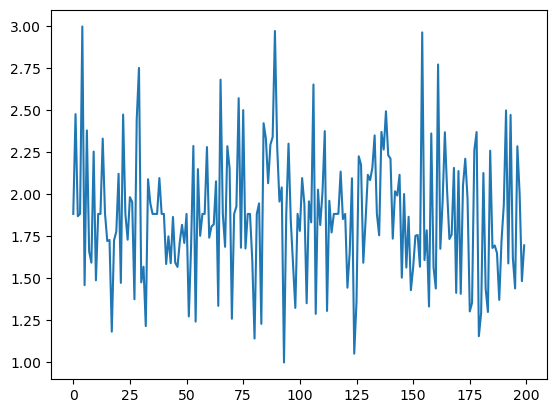

In [164]:
#test for plotting the time series generated to check for stationarity
#print(time_series)
plt.plot(time_series)